In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
data = pd.read_csv("AggregatedData.csv")

<h3> Convert Weekday column to Uppercase because of format mismatch </h3>

In [4]:
data['Weekday'] = data['Weekday'].str.upper()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11589 entries, 0 to 11588
Data columns (total 12 columns):
ATM Name                        11589 non-null object
Transaction Date                11589 non-null object
No Of Withdrawals               11589 non-null int64
No Of XYZ Card Withdrawals      11589 non-null int64
No Of Other Card Withdrawals    11589 non-null int64
Total amount Withdrawn          11589 non-null int64
Amount withdrawn XYZ Card       11589 non-null int64
Amount withdrawn Other Card     11589 non-null int64
Weekday                         11589 non-null object
Festival Religion               11589 non-null object
Working Day                     11589 non-null object
Holiday Sequence                11589 non-null object
dtypes: int64(6), object(6)
memory usage: 1.1+ MB


<h3> Convert Transaction Date column to Date Time object </h3>

In [6]:
import datetime 
data['Transaction Date'] = pd.to_datetime(data['Transaction Date']) 

In [7]:
data.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,2011-01-01,50,20,30,123800,41700,82100,SATURDAY,H,H,WHH
1,Mount Road ATM,2011-01-01,253,67,186,767900,270900,497000,SATURDAY,C,H,WHH
2,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,SATURDAY,C,H,WHH
3,KK Nagar ATM,2011-01-01,265,159,106,945300,532600,412700,SATURDAY,C,H,WHH
4,Christ College ATM,2011-01-01,74,25,49,287700,148200,139500,SATURDAY,C,H,WHH


<h3> Removing the XYZ and Other Card Withdrawn Amounts columns too because I think they will end up biasing the model too much because the Total Amount Withdrawn column is just the sum of these two columns </h3>
<h4> Actually the number of withdrawals should be removed too, because in a real-time scenario, we cannot really have that value but I'm keeping it in for now </h4>

In [8]:
new_data = data.drop(['Transaction Date', 'Amount withdrawn Other Card',
               'Amount withdrawn XYZ Card', 'No Of Withdrawals', 'No Of XYZ Card Withdrawals',
       'No Of Other Card Withdrawals'], axis = 1)

# y = data['Total amount Withdrawn']

<h3> Converting Transaction Date to separate columns, otherwise model won't accept it </h3>


In [9]:
new_data['Month'] = data['Transaction Date'].dt.month
new_data['Day'] = data['Transaction Date'].dt.day
new_data['Year'] = data['Transaction Date'].dt.year

In [10]:
new_data.columns

Index(['ATM Name', 'Total amount Withdrawn', 'Weekday', 'Festival Religion',
       'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year'],
      dtype='object')

<h3> Converting Categorical Columns to Boolean Columns using pd.get_dummies() </h3>

In [11]:
categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
numeric_features_list = []
testing_summary = dict()

In [12]:
# Convert all categorical columns to Dummy Data (One-Hot Encoding I think)
# drop_first = True to avoid the first column of each dummy column's result
# So if column = Gender and has two unique values Male and Female, get_dummies on this column creates two new columns
# male and female, if person male that column is 1 and the other is 0 and same for female column, but we only just need
# one of these columns, male or female, if male is 0 it guarantees person is female, for that reason drop_first=True
def convert_categorical_to_numerical(data, column_list):
    if 'ATM Name' in column_list:
        column_list.remove('ATM Name')
        temp_data = pd.get_dummies(data, columns=column_list , drop_first=True)
    
        # Do drop_first for all columns, except for ATM Name, because it becomes annoying later on
        return pd.get_dummies(temp_data, columns=['ATM Name'])
    else:
        return pd.get_dummies(data, columns=column_list, drop_first=True)


temp_numeric_data = convert_categorical_to_numerical(new_data, categorical_features_list)
numeric_data = temp_numeric_data.drop('ATM Name_KK Nagar ATM', axis=1)

In [13]:
numeric_data.head()

,Total amount Withdrawn,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,Weekday_WEDNESDAY,Festival Religion_H,Festival Religion_M,Festival Religion_N,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,ATM Name_Airport ATM,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_Mount Road ATM
0,123800,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,767900,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,503400,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,945300,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<h3> Train Test Split followed by Scaling all Columns </h3>
<h3> Since all columns are non-numeric, we don't really need scaling, so I commented it out for now </h3>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = numeric_data.drop('Total amount Withdrawn', axis=1)
y = numeric_data['Total amount Withdrawn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Note that we fit the scaler on X_train only and not X, otherwise test data will get biased on means and std of test data
# Instead it should use train data mean and std
# scaler = StandardScaler().fit(X_train)
# scaled_X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)
# scaled_X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

# scaled_X_train

<h3> KNN Implementation & Error Rate Visualization </h3>

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

error_rate = []
for k in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    error_rate.append(np.sqrt(mean_squared_error(y_test, predictions)))
    print("k={} Model Trained and Tested".format(k))

k=1 Model Trained and Tested
k=2 Model Trained and Tested
k=3 Model Trained and Tested
k=4 Model Trained and Tested
k=5 Model Trained and Tested
k=6 Model Trained and Tested
k=7 Model Trained and Tested
k=8 Model Trained and Tested
k=9 Model Trained and Tested
k=10 Model Trained and Tested
k=11 Model Trained and Tested
k=12 Model Trained and Tested
k=13 Model Trained and Tested
k=14 Model Trained and Tested
k=15 Model Trained and Tested
k=16 Model Trained and Tested
k=17 Model Trained and Tested
k=18 Model Trained and Tested
k=19 Model Trained and Tested
k=20 Model Trained and Tested
k=21 Model Trained and Tested
k=22 Model Trained and Tested
k=23 Model Trained and Tested
k=24 Model Trained and Tested
k=25 Model Trained and Tested
k=26 Model Trained and Tested
k=27 Model Trained and Tested
k=28 Model Trained and Tested
k=29 Model Trained and Tested
k=30 Model Trained and Tested
k=31 Model Trained and Tested
k=32 Model Trained and Tested
k=33 Model Trained and Tested
k=34 Model Trained 

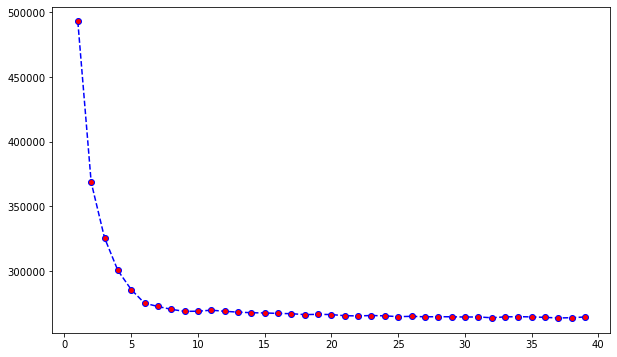

In [16]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, linestyle='--', marker='o', markerfacecolor='red', color='blue')

In [17]:
print("Best K:", error_rate.index(min(error_rate)))
print("Best RMSE:", min(error_rate))

Best K: 36
Best RMSE: 263821.32380546525


<h3> Best RMSE: 243180.0491744677 </h3>

<h2> Running Each Regression Model to get summary of all RMSEs </h2>
<h3> Models tested </h3>
<ul>
    <li> KNN </li>
    <li> Linear Regression </li>
    <li> Ridge </li>
    <li> Elasticnet </li>
    <li> Lasso </li>
    <li> Bayesian Ridge </li>
    <li> Support Vector Regression </li>
    <li> Random Forest Regression </li>
    <li> Decision Tree Regression </li>
</ul>

In [18]:
models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}

atm_names = new_data['ATM Name'].unique()

In [19]:
def compute_rmse_model_list(models, X_train, y_train, X_test, y_test):
    print("RMSEs for each model")
    testing_scores = dict()
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        model_predictions = model.predict(X_test)
        model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
        model_testing_score = model.score(X_test, y_test)
        model_training_score = model.score(X_train, y_train)
        print("For", model_name)
        print("\tTesting RMSE = {}".format(model_rmse))
        print("\tTraining Score =", model_training_score)
        print("\tTesting Score =", model_testing_score)
        
        # Storing the results in a dictionary, so stuff can be easily compared later
        testing_scores[model_name] = dict()
        testing_scores[model_name]['Training Score'] = model_training_score
        testing_scores[model_name]['Testing Score'] = model_testing_score
        testing_scores[model_name]['RMSE'] = model_rmse
    
    return testing_scores

In [20]:
testing_summary['All ATMs Trained with Train Test Split'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 263821.32380546525
	Training Score = 0.376755664209415
	Testing Score = 0.34976990282315645
For Vanilla Linear Regression
	Testing RMSE = 251419.8192235889
	Training Score = 0.4013361571445507
	Testing Score = 0.4094641102628562
For Ridge Linear Regression
	Testing RMSE = 251395.20976856566
	Training Score = 0.401303262994798
	Testing Score = 0.40957971018028033
For Elasticnet Linear Regression
	Testing RMSE = 309411.6362690149
	Training Score = 0.10900893738529349
	Testing Score = 0.10562312336992907
For Lasso Linear Regression
	Testing RMSE = 251416.0051469024
	Training Score = 0.40133597818305683
	Testing Score = 0.40948202716449345
For Bayesian Ridge Linear Regression
	Testing RMSE = 251414.41701770766
	Training Score = 0.4009356351971536
	Testing Score = 0.4094894874363259
For Support Vector Regression
	Testing RMSE = 330060.3547257065
	Training Score = -0.02381723071492714
	Testing Score = -0.017733339289077277
For Ran

<h3> The scores and RMSEs computed by the above function are stored in the dictionary in the following format </h3>

<h4> After observing the testing and training scores, I think its clear that Decision Tree overfits, but I dont think that was ever that high on our sought after models list, so that's good, other than that everything is not ideal but atleast no overfitting </h4>

<h3> Using only 2017 data as test data and everything else as training data </h3>

In [21]:
numeric_data

,Total amount Withdrawn,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,Weekday_WEDNESDAY,Festival Religion_H,Festival Religion_M,Festival Religion_N,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,ATM Name_Airport ATM,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_Mount Road ATM
0,123800,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,767900,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,503400,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,945300,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11584,468800,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
11585,305100,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
11586,709900,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
11587,408700,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data['Year_2017'] == 1]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1155


In [23]:
testing_summary['All ATMs Trained with 2017 Test Data'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 349507.030798516
	Training Score = 0.38667187416152216
	Testing Score = -0.07024480833352564
For Vanilla Linear Regression
	Testing RMSE = 351236.18526535534
	Training Score = 0.4535210215154458
	Testing Score = -0.080860883614569
For Ridge Linear Regression
	Testing RMSE = 350822.0331627114
	Training Score = 0.453491696908386
	Testing Score = -0.0783134416727651
For Elasticnet Linear Regression
	Testing RMSE = 341559.4825601102
	Training Score = 0.11927880563347205
	Testing Score = -0.02212495241294432
For Lasso Linear Regression
	Testing RMSE = 351203.8417642888
	Training Score = 0.4535207159268131
	Testing Score = -0.08066183114206793
For Bayesian Ridge Linear Regression
	Testing RMSE = 350009.66670241096
	Training Score = 0.45328800801809777
	Testing Score = -0.0733253202260633
For Support Vector Regression
	Testing RMSE = 339521.12487241626
	Training Score = -0.025157973486803265
	Testing Score = -0.009961686343598508
F

<h3> Random Forest and Decision Tree overfit here but everything else is trash for both training and testing, idk what can be done about this </h3>

<h3> Finding out the total amount withdrawn per month per year </h3>

In [24]:
new_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
1,Mount Road ATM,767900,SATURDAY,C,H,WHH,1,1,2011
2,Airport ATM,503400,SATURDAY,C,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
4,Christ College ATM,287700,SATURDAY,C,H,WHH,1,1,2011
...,...,...,...,...,...,...,...,...,...
11584,Big Street ATM,468800,FRIDAY,H,H,WHH,9,29,2017
11585,Mount Road ATM,305100,FRIDAY,H,H,WHH,9,29,2017
11586,Airport ATM,709900,FRIDAY,H,H,WHH,9,29,2017
11587,KK Nagar ATM,408700,FRIDAY,H,H,WHH,9,29,2017


In [25]:
# Takes like 15-20 seconds to compute
total_amt_per_mon_per_yr = {}
for year in new_data['Year'].unique():
    for month in new_data['Month'].unique():
        total_amt_per_mon_per_yr[(year, month)] = sum(new_data[new_data.apply(lambda x: x['Year'] == year
                            and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

<p> total_amt_per_mon_per_yr is basically a dictionary whose key is a tuple (year, month) and its value contains the total amount withdrawn in the month of the year specified in the key, so (2011, 1): 65360200, means that 65360200 was withdrawn in total in the month of January 2011 </p>

In [26]:
from pprint import pprint

# Uncomment this if you want to see what the dictionary is like but its a big list and takes up space so I commented it out
# pprint(total_amt_per_mon_per_yr)

In [27]:
total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
print("Total Amount Withdrawn:", total_amount_withdrawn)
print("Average Amount Withdrawn:", avg_amount_withdrawn)

Total Amount Withdrawn: 6053002800
Average Amount Withdrawn: 72059557.14285715


<h3> Figuring out Outlier Months </h3>
<p> So my logic is that I take the total amount withdrawn in each month (of each year ofc) and then check its difference from the average amount withdrawn per month per year, and there's a tolerance percent variable (currently 0.7), so if the difference (positive or negative) is greater than 70% of the avg_amount_withdrawn, then that month of that year is an outlier </p>
<p> I think something similar can be done with days in a month as well </p>

In [28]:
tolerance_percent = 0.7

for key in total_amt_per_mon_per_yr:
    amount = total_amt_per_mon_per_yr[key]
    if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
        print(key)
        # print(total_amt_per_mon_per_yr[key])

(2016, 11)
(2016, 12)
(2017, 10)
(2017, 11)
(2017, 12)


<h3> Removing outlier months from 2017 in test set </h3>

In [29]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data.apply(lambda x: x['Year_2017'] == 1
                            and x['Month_10'] != 1 and x['Month_11'] != 1 and x['Month_12'] != 1, axis=1)]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1053


In [30]:
# testing_summary_all_atms_with_2017_non_outlier_month_data = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)
testing_summary['All ATMs Trained with 2017 Test Data (No Outlier Months)'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 351022.25503262907
	Training Score = 0.38667187416152216
	Testing Score = -0.06821091445126548
For Vanilla Linear Regression
	Testing RMSE = 351707.41076749505
	Training Score = 0.4535210215154458
	Testing Score = -0.0723850379299813
For Ridge Linear Regression
	Testing RMSE = 351324.7551906196
	Training Score = 0.453491696908386
	Testing Score = -0.07005281022397458
For Elasticnet Linear Regression
	Testing RMSE = 343412.7436405998
	Training Score = 0.11927880563347205
	Testing Score = -0.022399249112364794
For Lasso Linear Regression
	Testing RMSE = 351678.3929187876
	Training Score = 0.4535207159268131
	Testing Score = -0.0722080895796422
For Bayesian Ridge Linear Regression
	Testing RMSE = 350563.3036768458
	Training Score = 0.45328800801809777
	Testing Score = -0.06541943133494232
For Support Vector Regression
	Testing RMSE = 341482.3478579618
	Training Score = -0.025157973486803265
	Testing Score = -0.01093730936595171

<h3> A slight improvement but pretty insignificant sadly </h3>

<h3> Figuring out Outlier Days with 75% difference from the average amount withdrawn per day as the tolerance</h3>

In [31]:
avg_amount_withdrawn_per_day = sum(new_data['Total amount Withdrawn']) / len(new_data['Total amount Withdrawn'])
tolerance_percent = 0.75

outlier_day_data = new_data[new_data.apply(lambda x: abs(avg_amount_withdrawn_per_day - x['Total amount Withdrawn']) > 
                            avg_amount_withdrawn_per_day * tolerance_percent, axis=1)]

In [32]:
outlier_day_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
5,Big Street ATM,52800,SUNDAY,NH,H,HHW,2,1,2011
10,Big Street ATM,88100,MONDAY,NH,W,WWW,3,1,2011
13,KK Nagar ATM,1333100,MONDAY,NH,W,WWW,3,1,2011
...,...,...,...,...,...,...,...,...,...
11558,Christ College ATM,1253100,SATURDAY,NH,H,WHH,9,23,2017
11567,KK Nagar ATM,1175200,MONDAY,NH,W,HWW,9,25,2017
11577,KK Nagar ATM,997800,WEDNESDAY,NH,W,WWW,9,27,2017
11582,KK Nagar ATM,1154900,THURSDAY,NH,W,WWH,9,28,2017


In [33]:
# Kinda useless, prints a really big list that's all
# for idx, row in outlier_day_data.iterrows():
#     print("{}, {}, {}".format(row['Year'], row['Month'], row['Day']))

<p> I used value_counts() on Month, Day and Year of the outlier df but it contains data of multiple ATMs, so I split them to figure out the actual numbers </p>

In [34]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Month'].value_counts(), "\n")

For ATM: Big Street ATM
11    42
3     42
4     40
1     40
7     38
8     34
2     34
6     31
5     27
12    25
10    22
9     20
Name: Month, dtype: int64 

For ATM: KK Nagar ATM
1     95
5     85
8     84
10    83
7     83
11    82
3     82
6     78
4     77
2     76
9     74
12    69
Name: Month, dtype: int64 

For ATM: Christ College ATM
5     38
1     35
4     34
3     33
10    29
8     26
7     26
6     26
2     24
11    16
9     15
12    10
Name: Month, dtype: int64 

For ATM: Airport ATM
1     23
7     22
5     19
3     18
6     17
2     17
11    16
10    16
4     15
9     14
8     14
12    11
Name: Month, dtype: int64 

For ATM: Mount Road ATM
6     40
4     39
5     36
3     36
1     34
8     26
7     25
11    24
10    22
2     20
9     14
12    11
Name: Month, dtype: int64 



<h3> Basically KK Nagar ATM has vastly large number of outlier days as compared to the others and Airport ATM is the best in this regard </h3>

In [35]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Year'].value_counts(), "\n")

For ATM: Big Street ATM
2011    243
2012     78
2016     30
2017     24
2014      8
2015      7
2013      5
Name: Year, dtype: int64 

For ATM: KK Nagar ATM
2013    260
2014    258
2012    157
2016     86
2017     85
2015     69
2011     53
Name: Year, dtype: int64 

For ATM: Christ College ATM
2017    92
2014    75
2016    69
2015    34
2013    19
2012    12
2011    11
Name: Year, dtype: int64 

For ATM: Airport ATM
2016    68
2017    54
2015    35
2014    17
2013    14
2012    11
2011     3
Name: Year, dtype: int64 

For ATM: Mount Road ATM
2016    106
2015     54
2014     54
2017     50
2012     30
2013     24
2011      9
Name: Year, dtype: int64 



<h3> Training all models for each ATM separately and the results might shock you! </h3>

In [36]:
def model_training_per_atm(atm_name):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    ''' Finding Outlier Months for each bank separately
    print("\nOutlier Months for bank {} are as follows,".format(bank_name))
    total_amt_per_mon_per_yr = {}
    for year in curr_bank_data['Year'].unique():
       for month in curr_bank_data['Month'].unique():
           total_amt_per_mon_per_yr[(year, month)] = sum(curr_bank_data[curr_bank_data.apply(lambda x: x['Year'] == year
                               and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

    total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
    avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
    # print("Total Amount Withdrawn:", total_amount_withdrawn)
    # print("Average Amount Withdrawn:", avg_amount_withdrawn)

    tolerance_percent = 0.7

    for key in total_amt_per_mon_per_yr:
        amount = total_amt_per_mon_per_yr[key]
        if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
            print(key)
    '''
    
    # This takes 2016 data as test data and ignores 2017 data completely
    # train_data = numeric_curr_bank_data[numeric_curr_bank_data.apply(lambda x: x['Year_2017'] == 0 and 
    #                                                                 x['Year_2016'] == 0, axis=1)]
    # test_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2016'] == 1]
    # Conclusions: For some reason, Airport ATM accuracy increases slightly somehow but everything else gets rekt
    
    
    print("\nFor ATM:", atm_name)
    print("Number of training rows:",len(train_data))
    print("Number of testing rows:", len(test_data))
    print()

    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    testing_dict_curr_atm = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)
    return testing_dict_curr_atm

In [37]:
for atm_name in new_data['ATM Name'].unique():
    testing_dict_curr_atm = model_training_per_atm(atm_name)
    testing_summary[atm_name + ' trained with 2017 Data'] = testing_dict_curr_atm
    
# Note: Bayesian Ridge Linear Regression does not converge for the Mount Road and KK Nagar models and increasing n_iter
# to even 5000 (default is 350) didn't change that at all, so that's sad


For ATM: Big Street ATM
Number of training rows: 2117
Number of testing rows: 237

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 181461.59767223545
	Training Score = 0.28999562819250424
	Testing Score = -0.36556725432459025
For Vanilla Linear Regression
	Testing RMSE = 276512.2844681913
	Training Score = 0.5444464813526175
	Testing Score = -2.1708266083172028
For Ridge Linear Regression
	Testing RMSE = 273587.69620255945
	Training Score = 0.5442115519020725
	Testing Score = -2.104107536431348
For Elasticnet Linear Regression
	Testing RMSE = 160736.02690753856
	Training Score = 0.13017936078590775
	Testing Score = -0.07144551642773656
For Lasso Linear Regression
	Testing RMSE = 276469.1320024553
	Training Score = 0.5444461398934355
	Testing Score = -2.169837008089656
For Bayesian Ridge Linear Regression
	Testing RMSE = 270701.1207086409
	Training Score = 0.5436357614309526
	Testing Score = -2.038951303826138
For Support Vector Regression
	Testing RMSE = 158495.819471549

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318209236896.22656, tolerance: 12393046096.022762
  model = cd_fast.enet_coordinate_descent(


 Bayesian Ridge Linear Regression
	Testing RMSE = 324014.4789707869
	Training Score = 0.5135989086530637
	Testing Score = -2.0427218501556643
For Support Vector Regression
	Testing RMSE = 322190.0963087881
	Training Score = -0.00016256288294114185
	Testing Score = -2.0085538639651888
For Random Forest Regression
	Testing RMSE = 329908.39907994063
	Training Score = 0.9217026970133028
	Testing Score = -2.1544246849018993
For Decision Tree Regression
	Testing RMSE = 351033.3047786631
	Training Score = 1.0
	Testing Score = -2.571330670147686

For ATM: Airport ATM
Number of training rows: 2058
Number of testing rows: 195

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 280998.75391993637
	Training Score = 0.21011877894017894
	Testing Score = -0.320081646974691
For Vanilla Linear Regression
	Testing RMSE = 270419.38396096433
	Training Score = 0.32222981007075846
	Testing Score = -0.2225528522966016
For Ridge Linear Regression
	Testing RMSE = 270340.7285163081
	Training Score = 

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4886918595366.969, tolerance: 40041415972.54263
  model = cd_fast.enet_coordinate_descent(


For Support Vector Regression
	Testing RMSE = 476342.10707451584
	Training Score = -0.010162086368770362
	Testing Score = -0.641280726160238
For Random Forest Regression
	Testing RMSE = 448783.7496259357
	Training Score = 0.9302856073280882
	Testing Score = -0.4568645252661532
For Decision Tree Regression
	Testing RMSE = 475371.07610791805
	Training Score = 1.0
	Testing Score = -0.6345959928147875

For ATM: Christ College ATM
Number of training rows: 2115
Number of testing rows: 240

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 454068.21878890437
	Training Score = 0.2887955781878394
	Testing Score = -0.48406666444966473
For Vanilla Linear Regression
	Testing RMSE = 563369.5987146889
	Training Score = 0.4884805976915243
	Testing Score = -1.2845360365183236
For Ridge Linear Regression
	Testing RMSE = 559635.1538683609
	Training Score = 0.487886260442293
	Testing Score = -1.254349113835958
For Elasticnet Linear Regression
	Testing RMSE = 437212.60466702207
	Training Score

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303677188912.1094, tolerance: 13354579722.531445
  model = cd_fast.enet_coordinate_descent(


For Support Vector Regression
	Testing RMSE = 464427.1776615809
	Training Score = -0.01517727140145797
	Testing Score = -0.552553057061139
For Random Forest Regression
	Testing RMSE = 571168.3598554188
	Training Score = 0.9174690716103661
	Testing Score = -1.3482237780287183
For Decision Tree Regression
	Testing RMSE = 576741.9604988005
	Training Score = 1.0
	Testing Score = -1.394276468402862


<p> I know the output is a bit long, but read it for cool insights and damn Big Street ATM is the OP right now, SVR got 1 lakh 58 thousand RMSE on it </p>

<h3> Upto this point, removing outlier months from test set has had no effect, be it for the model with all ATMs or for individual ATMs, infact it made the RMSE worse at times, so I think we can stop pursuing the outlier month part for now </h3>

<h2> Hyperparameter Tuning </h2>
<p> Right now, just focused on SVR as it performs the best consistently </p>
<p> Note that the function below this cell takes the bank_name and the random search or grid search object and does all the tasks of converting to numeric data, train test split using 2017 data and then does Cross Validation and then computes the RMSE on the best estimator found after hyperparameter search </p>

In [38]:
# Works for both RandomizedSearchCV() object and GridSearchCV() object
def model_training_hyperparam_per_atm(atm_name, param_cv_obj):
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    # test_indices_to_keep = sorted(list(set(temp_test_data.index) - set(outlier_day_data.index)))
    
    # print(test_indices_to_keep)
    # print(temp_test_data.index)
    # test_data = temp_test_data.take(test_indices_to_keep)
    
    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    param_cv_obj.fit(X_train, y_train)
    print("Best Parameters:\n", param_cv_obj.best_params_)
    print("\nBest Score:", param_cv_obj.best_score_)
    
    best_model = param_cv_obj.best_estimator_
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print("Test RMSE:", model_rmse)

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

svr_param_grid = {'C': list(np.logspace(np.log10(0.001), np.log10(1000), num=25)),
                         'epsilon': list(np.logspace(np.log10(0.001), np.log10(1000), num=25))}

random_cv_svr = RandomizedSearchCV(SVR(), svr_param_grid, n_iter=50, cv=10, verbose=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_cv_svr = GridSearchCV(SVR(), svr_param_grid, verbose=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

<h3> SVR Randomized Search for all ATMs individually </h3>

In [40]:
model_training_hyperparam_per_atm('Christ College ATM', random_cv_svr)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 177.82794100389228, 'C': 1000.0}

Best Score: -248425.02133705173
Test RMSE: 458465.7883776411


<h3> There's a big difference in the CV and Test RMSE for Christ College, so it probably means that our test set is not so good considering we are not using normal train-test split </h3>

<p> CV RMSE: -248436.58633545385 <br> Test RMSE: 458393.93110469 </p>

In [41]:
for atm_name in atm_names:
    print("\nPerforming Random Search with SVR on", atm_name, "\n")
    # model_training_hyperparam_per_atm(atm_name, grid_cv_svr)
    model_training_hyperparam_per_atm(atm_name, random_cv_svr)


Performing Random Search with SVR on Big Street ATM 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 0.01, 'C': 1000.0}

Best Score: -157505.96471867283
Test RMSE: 158667.2245605045

Performing Random Search with SVR on Mount Road ATM 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Best Parameters:
 {'epsilon': 0.0017782794100389228, 'C': 1000.0}

Best Score: -240273.563879369
Test RMSE: 321926.99321987526

Performing Random Search with SVR on Airport ATM 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Best Parameters:
 {'epsilon': 5.623413251903491, 'C': 1000.0}

Best Score: -193097.65343665896
Test RMSE: 275428.75423243525

Performing Random Search with SVR on KK Nagar ATM 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 56.23413251903491, 'C': 562.341325190349}

Best Score: -437791.51244166447
Test RMSE: 477182.97760147636

Performing Random Search with SVR on Christ College ATM 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 0.01, 'C': 1000.0}

Best Score: -248436.60000969804
Test RMSE: 458393.7021660285


<h3> Training Model on All ATMs but using Test Data from individual ATMs </h3>

In [42]:
def all_atm_model_training_with_different_test_atms(data):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    atm_names = data['ATM Name'].unique()
    
    numeric_data = convert_categorical_to_numerical(data, categorical_features_list)
    
    train_data = numeric_data[numeric_data['Year_2017'] == 0]
    test_data = numeric_data[numeric_data['Year_2017'] == 1]
    
    for atm_name in atm_names:
        print("\nFor ATM:", atm_name)
        
        # I know this is sad jugaad, but its honest work and yeah Airport ATM column gets dropped in pd.get_dummies
        # so I'm just using that knowledge to hardcode column names here
        # if atm_name != 'Airport ATM':
        '''
            if 'ATM Name_' + atm_name in test_data.columns:
                curr_atm_test_data = test_data[test_data['ATM Name_' + atm_name] == 1]
            else:
                curr_atm_test_data = test_data[test_data.apply(
                    lambda x: x['ATM Name_Big Street ATM'] == 0 and x['ATM Name_Mount Road ATM'] == 0
                            and x['ATM Name_KK Nagar ATM'] == 0 and x['ATM Name_Christ College ATM'] == 0, axis=1)]

                curr_atm_test_data = test_data[test_data.apply(
                    lambda x: [x[a_name] == 0 for a_name in atm_names], axis=1)]
        '''
        
        X_train = train_data.drop(['Total amount Withdrawn', 'ATM Name_' + atm_names[0]], axis=1)
        y_train = train_data['Total amount Withdrawn']
        
        curr_atm_test_data = test_data[test_data['ATM Name_' + atm_name] == 1]
        X_test = curr_atm_test_data.drop(['Total amount Withdrawn', 'ATM Name_' + atm_names[0]], axis=1)
        y_test = curr_atm_test_data['Total amount Withdrawn']

        compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

<h4> Tbh idk what to make of this result, its weird. In some ways, the trash ATMs are performing trash but some models are performing quite well on Mount Road ATM which didn't happen with the individual model, so I guess KK and Christ College are the ones that we need to destroy </h4>

In [43]:
all_atm_model_training_with_different_test_atms(new_data)


For ATM: Big Street ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 160761.22195743438
	Training Score = 0.4327735808352957
	Testing Score = -0.07178143662536951
For Vanilla Linear Regression
	Testing RMSE = 220189.09903158937
	Training Score = 0.4535210215154458
	Testing Score = -1.010644370788854
For Ridge Linear Regression
	Testing RMSE = 219278.1361879842
	Training Score = 0.4534921286886008
	Testing Score = -0.9940419736478675
For Elasticnet Linear Regression
	Testing RMSE = 230626.41352311775
	Training Score = 0.146904990423854
	Testing Score = -1.2057776103883073
For Lasso Linear Regression
	Testing RMSE = 220135.20854777785
	Training Score = 0.4535207159235627
	Testing Score = -1.009660295385542
For Bayesian Ridge Linear Regression
	Testing RMSE = 216769.0031492237
	Training Score = 0.4532224416363815
	Testing Score = -0.9486686321193216
For Support Vector Regression
	Testing RMSE = 206796.59945379852
	Training Score = -0.02521686557734082
	Testing Score = -0

<h3> Doing the same as above but just using data from Big Street, Mount Road and Airport ATMs </h3>

In [44]:
good_data = new_data[new_data.apply(lambda x: x['ATM Name'] != 'KK Nagar ATM' 
                                    and x['ATM Name'] != 'Christ College ATM', axis=1)]

all_atm_model_training_with_different_test_atms(good_data)


For ATM: Big Street ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 158618.10337009552
	Training Score = 0.3840104394960905
	Testing Score = -0.043395930938965765
For Vanilla Linear Regression
	Testing RMSE = 188278.79850039512
	Training Score = 0.3888530973235256
	Testing Score = -0.4700986198565593
For Ridge Linear Regression
	Testing RMSE = 187658.3412392558
	Training Score = 0.38878449463634546
	Testing Score = -0.4604254071488416
For Elasticnet Linear Regression
	Testing RMSE = 167807.48386731514
	Training Score = 0.13052242796752922
	Testing Score = -0.16779412109203484


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 188247.22492758566
	Training Score = 0.3888525917818654
	Testing Score = -0.46960560232858234
For Bayesian Ridge Linear Regression
	Testing RMSE = 185031.07441716632
	Training Score = 0.3878119473737709
	Testing Score = -0.4198189711009328
For Support Vector Regression
	Testing RMSE = 174880.2829468054
	Training Score = -0.0013433259042736623
	Testing Score = -0.2683097411069155
For Random Forest Regression
	Testing RMSE = 274300.34988959227
	Training Score = 0.9301733587889188
	Testing Score = -2.120300039755443
For Decision Tree Regression
	Testing RMSE = 274079.3766881018
	Training Score = 1.0
	Testing Score = -2.115274709222968

For ATM: Mount Road ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 294469.2194498337
	Training Score = 0.3840104394960905
	Testing Score = -1.513120011264927
For Vanilla Linear Regression
	Testing RMSE = 262493.3873361208
	Training Score = 0.3888530973235256
	Testing Score = -0.9969636172379583


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 262515.15381622716
	Training Score = 0.3888525917818654
	Testing Score = -0.9972948154557034
For Bayesian Ridge Linear Regression
	Testing RMSE = 264676.80225273105
	Training Score = 0.3878119473737709
	Testing Score = -1.0303231942122686
For Support Vector Regression
	Testing RMSE = 237358.8875030304
	Training Score = -0.0013433259042736623
	Testing Score = -0.6328429429423257
For Random Forest Regression
	Testing RMSE = 330958.62926677166
	Training Score = 0.9293786937421639
	Testing Score = -2.1745402389936923
For Decision Tree Regression
	Testing RMSE = 353042.5494216351
	Training Score = 1.0
	Testing Score = -2.6123308430175896

For ATM: Airport ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 265539.25392855983
	Training Score = 0.3840104394960905
	Testing Score = -0.1788253497447605
For Vanilla Linear Regression
	Testing RMSE = 247679.74538280914
	Training Score = 0.3888530973235256
	Testing Score = -0.0255881403415159

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 247683.33469720022
	Training Score = 0.3888525917818654
	Testing Score = -0.025617865702699305
For Bayesian Ridge Linear Regression
	Testing RMSE = 247814.57944030146
	Training Score = 0.3878119473737709
	Testing Score = -0.026705081496683825
For Support Vector Regression
	Testing RMSE = 262533.8514480243
	Training Score = -0.0013433259042736623
	Testing Score = -0.15229220690026346
For Random Forest Regression
	Testing RMSE = 276778.72441148956
	Training Score = 0.9299957724280646
	Testing Score = -0.28072949675867287
For Decision Tree Regression
	Testing RMSE = 286474.5530382437
	Training Score = 1.0
	Testing Score = -0.37203157502015816


<h3> Conclusions: </h3>
<p> For Big Street ATM: Before, Best Performance = 160761 by KNN with k = 37. Now, it is 158618 also by KNN with k = 37, so an improvement</p>
<p> For Mount Road ATM: Before, Best Performance = 236570 by Vanilla LR with k = 37. Now, it is 237358 by SVR, so performance worsened somehow </p>
<p> For Airport ATM: Before, Best Performance = 251569 by Bayesian Ridge. Now, it is 247664 by Ridge, so performance increased </p>
<p> In summary, we got an improvement of 2k for Big Street, a decrement of 1k for Mount Road and an increment of 4k for Airport. So its definitely helping improve our cause but man that's still very marginal improvement </p>



<h3> Hyperparameter Tuning for Lasso </h3>
<p> Alpha is the only tunable parameter here </p>

<h3> Plotting Validation Curve For Lasso Regression => Train Error vs Cross Validation Error (Y-Axis) wrt alpha (X-Axis) </h3>

<p> Note that the validation_curve() method returns the train_score and validation_scores. These scores are an array of dimension (n_ticks, n_cv_folds). I chose cv=10, so n_cv_folds=10, n_ticks = number of values that the parameter being tested again takes, here that parameter is alpha and I used 50 values of alpha in the range 10^-3 to 10^3 (log-spaced) </p>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   28.4s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.8s finished


AttributeError: 'str' object has no attribute 'pop'

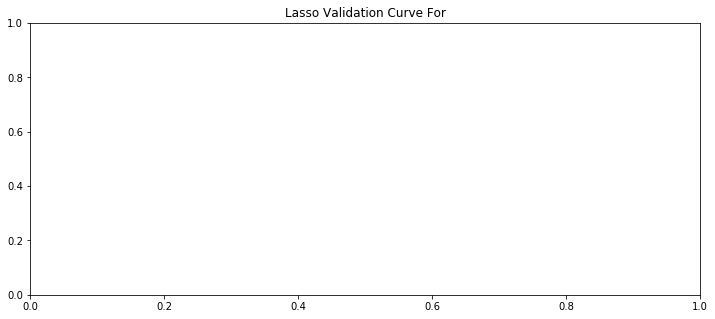

In [85]:
from sklearn.model_selection import validation_curve

alphas = np.logspace(-3, 3, num=50)
lasso = Lasso(max_iter=5000)

for atm_name in atm_names:
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']

    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)

    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]

    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']

    train_scores, valid_scores = validation_curve(lasso, X_train, y_train, "alpha", 
                                                  alphas, cv=10, 
                                                  scoring='neg_root_mean_squared_error',
                                                 verbose=2, n_jobs=-1)
    
    # The scoring used was neg_root_mean_squared_error, so I multiply each element by -1 to get its positive equivalent
    train_scores = np.array([-1 * x for x in train_scores])
    valid_scores = np.array([-1 * x for x in valid_scores])
    
    # Taking the mean of the 10 CV errors and converting train_scores and valid_scores to an array of size n_ticks = 50
    train_scores_mean = np.mean(train_scores, axis=1) 
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    plt.figure(figsize=(12, 5))
    plt.title("Lasso Validation Curve For {}".format(atm_name))
    plt.xlabel("alpha")
    plt.ylabel("RMSE")
    lw = 2
    
    # Note semilogx is just plot function where the X-axis is scaled according to logscale
    plt.semilogx(alphas, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.semilogx(alphas, valid_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    # print(train_scores.shape)

In [67]:
# lasso_param_grid = {'alpha':[0.005, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.5, 1]}
lasso_param_grid = {'alpha':[3, 3.5, 5, 10, 20, 30]}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=5, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=10)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, grid_cv_lasso)


For Big Street ATM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 30}

Best Score: -114938.39615861795
Test RMSE: 275267.13538999046

For Mount Road ATM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 30}

Best Score: -182702.97371287917
Test RMSE: 323004.6224465292

For Airport ATM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 30}

Best Score: -177859.08516294783
Test RMSE: 270555.28498196567

For KK Nagar ATM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 30}

Best Score: -346205.775131947
Test RMSE: 455174.1379231289

For Christ College ATM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s


Best Parameters:
 {'alpha': 30}

Best Score: -188854.2752544846
Test RMSE: 562264.9957994054


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished


<p> All in all, not very useful. But something's weird, in the best parameter results. For each ATM, either the first alpha value in the list is selected as the best parameter (alpha=0.005 currently) or the last alpha value (alpha=1 currently) so that's definitely something to note </p>

<h3> Hyperparameter Tuning for Ridge </h3>
<p> Alpha is again the only tunable parameter here, Note that I used mean_squared_error as the scoring parameter here instead of the default R squared metric, but it still didn't make a difference in the weird behaviour I noted above </p>

In [46]:
# ridge_param_grid = {'alpha':[125, 150, 175, 200, 230, 250,265, 270, 275, 290, 300, 500, 750, 800]}
ridge_param_grid = {'alpha':[300, 500, 750, 800, 1000, 1200, 1400, 2000, 4000, 5000, 10000]}
grid_cv_ridge = GridSearchCV(Ridge(), ridge_param_grid, verbose=5, n_jobs=-1, scoring='neg_mean_squared_error')

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, grid_cv_ridge)


For Big Street ATM
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


Best Parameters:
 {'alpha': 300}

Best Score: -28573645730.009846
Test RMSE: 167237.2827663761

For Mount Road ATM
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


Best Parameters:
 {'alpha': 300}

Best Score: -59943055536.349144
Test RMSE: 324270.4987718039

For Airport ATM
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


Best Parameters:
 {'alpha': 300}

Best Score: -40083222435.99373
Test RMSE: 274078.6799585757

For KK Nagar ATM
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


Best Parameters:
 {'alpha': 300}

Best Score: -175963034847.3803
Test RMSE: 499684.2321991951

For Christ College ATM
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters:
 {'alpha': 300}

Best Score: -61291171904.104126
Test RMSE: 442385.97213670355


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.2s finished


In [60]:
# Doing GridSearch manually to verify results

# from sklearn.model_selection import cross_val_score

# alphas = [0.005, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.5, 1]
# # alphas = [0.09, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 1.5, 2]

for atm_name in atm_names:
    val_errors = []
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        # lasso.fit(X_train, y_train)
        errors = np.mean(-cross_val_score(estimator=lasso, X=X_train, y=y_train, 
                                         scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1))
        
        val_errors.append(errors)

#     # print(val_errors)
#     best_alpha = alphas[np.argmin(val_errors)]
#     best_cv_rmse = min(val_errors)
    
#     print("For {}, the best CV RMSE was {} with alpha = {}".format(atm_name, best_cv_rmse, best_alpha))

For Big Street ATM, the best CV RMSE was 115241.06043251255 with alpha = 1
For Mount Road ATM, the best CV RMSE was 182809.087357492 with alpha = 1
For Airport ATM, the best CV RMSE was 178222.93269893242 with alpha = 1
For KK Nagar ATM, the best CV RMSE was 346498.30954520905 with alpha = 1
For Christ College ATM, the best CV RMSE was 189123.80163207793 with alpha = 1


<h3> Really Doubting Hyperparameter Tuning Now </h3>
<p> I think I'm doing something wrong at this point, because whenever I add a higher element to the alpha parameter of the tuning grid, GridSearch always selects that value, even when I changed the scoring from the default r2 score to mean_squared_error(), this trend still continues <p>

<h3> Storing Testing Summary as JSON File </h3>

In [47]:
# import json
# with open('testing_summary.json', 'w') as file:
#     json_string = json.dumps(testing_summary, default=lambda o: o.__dict__, indent=4)
#     file.write(json_string)
    